## BMI Calculator

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image

In [3]:
# Define state
class BMIState(TypedDict):

    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [4]:
def calculate_bmi(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state["height_m"]

    bmi = weight/(height**2)

    state["bmi"] = round(bmi, 2)

    return state

In [5]:
def label_bmi(state: BMIState) -> BMIState:
    bmi = state["bmi"]

    if bmi < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= bmi < 25:
        state["category"] = "Normal"
    elif 25 <= bmi < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"

    return state


In [6]:
# Define Graph
graph = StateGraph(BMIState)

# Add nodes to graph
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)

# Add edges to graph
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'label_bmi')
graph.add_edge('label_bmi', END)

# Compile the graph 
workflow = graph.compile()

In [7]:
# Execute the graph
initial_state = {"weight_kg": 64, "height_m": 1.68}
final_state = workflow.invoke(initial_state)
print(final_state)

{'weight_kg': 64, 'height_m': 1.68, 'bmi': 22.68, 'category': 'Normal'}


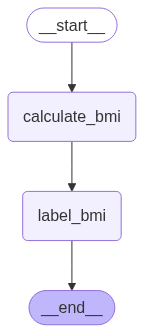

In [8]:
Image(workflow.get_graph().draw_mermaid_png())

## LLM Workflow

In [9]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_groq import ChatGroq
from IPython.display import Image
from dotenv import load_dotenv

In [10]:
load_dotenv()

True

In [11]:
model = llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

In [12]:
# Define State

class LLMState(TypedDict):

    question: str
    answer: str

In [13]:
def llm_qa(state: LLMState) -> LLMState:
    
    # Extract the question from state
    question = state["question"]

    # Form a prompt
    prompt = f"Answer the following question {question}"

    # Ask the questions
    answer = model.invoke(prompt).content

    # Update the answer in the state

    state["answer"] = answer

    return state

In [14]:
# Define the Graph
graph = StateGraph(LLMState)

# Add nodes to Graph
graph.add_node("llm_qa", llm_qa)

# Add edges to the graph
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)

# Compile
workflow = graph.compile()

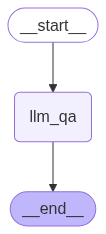

In [15]:
Image(workflow.get_graph().draw_mermaid_png())

In [16]:
initial_state = {"question": "How far is moon from the Earth?"}

final_state = workflow.invoke(initial_state)
print(final_state["answer"])

The Moon's distance from Earth is not constant due to its elliptical orbit. Here are the key points:

1. **Elliptical Orbit**: The Moon orbits Earth in an ellipse, leading to varying distances. The closest point is called perigee, and the farthest is apogee.

2. **Average Distance**: The average distance from Earth to the Moon is approximately 238,900 miles (384,400 kilometers).

3. **Perigee and Apogee**: 
   - Perigee: The Moon is about 225,622 miles (363,300 kilometers) away.
   - Apogee: The Moon is approximately 252,088 miles (405,500 kilometers) away.

4. **Tidal Effects**: The varying distance affects Earth's tides, with closer distances resulting in stronger gravitational pull and more pronounced tides.

5. **Increasing Distance**: The Moon is slowly moving away from Earth at a rate of about 1.5 inches (3.8 centimeters) per year due to tidal interactions.

These factors collectively describe the Moon's varying distance from Earth and its gradual movement away over time.


## Pompt Chaining

In [17]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image
from dotenv import load_dotenv
from langchain_groq import ChatGroq

In [18]:
load_dotenv()

True

In [19]:
model = llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

In [20]:
# Define State

class BlogState(TypedDict):

    title: str
    outline: str
    content: str

In [21]:
def create_outline(state: BlogState) -> BlogState:

    # fetch title
    title = state["title"]

    # call llm gen outline
    prompt = f"Generate a detailed outline for a blog on the topic - {title}"
    outline = model.invoke(prompt).content

    # Update state

    state["outline"] = outline

    return state

In [22]:
def create_blog(state: BlogState) -> BlogState:

    # fetch title
    title = state["title"]
    outline = state["outline"]

    prompt = f"Write a etailed blog on the title - {title} using the following outline \n {outline}"
    content = model.invoke(prompt).content

    # Update state

    state["content"] = content

    return state

In [23]:
# Define graph

graph = StateGraph(BlogState)

# Define Nodes
graph.add_node("create_outline", create_outline)
graph.add_node("create_blog", create_blog)

# Define Edges
graph.add_edge(START, "create_outline")
graph.add_edge("create_outline", "create_blog")
graph.add_edge("create_blog", END)


# Compile
workflow = graph.compile()


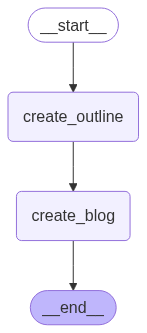

In [24]:
Image(workflow.get_graph().draw_mermaid_png())

In [25]:
initial_state = {"title": "Rise of AI in Bangladesh"}
final_state = workflow.invoke(initial_state)
print(final_state)

{'title': 'Rise of AI in Bangladesh', 'outline': '**Detailed Outline for Blog: "The Rise of AI in Bangladesh"**\n\n---\n\n**I. Introduction**\n   - **Global Context of AI**: Brief overview of AI\'s growing importance worldwide.\n   - **Bangladesh\'s Unique Position**: Highlight Bangladesh\'s economic growth and young population as a unique case for AI adoption.\n\n**II. Background on Artificial Intelligence**\n   - **Definition and Evolution**: Explain AI, its history, and modern advancements.\n   - **Global Impact**: Discuss AI\'s influence across industries globally.\n\n**III. Bangladesh\'s Tech Landscape**\n   - **Current IT Sector Development**: Overview of the IT sector\'s growth.\n   - **Government Initiatives**: Discuss "Digital Bangladesh" and other tech-promoting policies.\n   - **Startup Ecosystem**: Growth of startups and innovation hubs.\n\n**IV. Key Sectors Impacted by AI in Bangladesh**\n   - **Healthcare**: AI applications in diagnostics, telemedicine, and personalized t

In [26]:
print(final_state["outline"])

**Detailed Outline for Blog: "The Rise of AI in Bangladesh"**

---

**I. Introduction**
   - **Global Context of AI**: Brief overview of AI's growing importance worldwide.
   - **Bangladesh's Unique Position**: Highlight Bangladesh's economic growth and young population as a unique case for AI adoption.

**II. Background on Artificial Intelligence**
   - **Definition and Evolution**: Explain AI, its history, and modern advancements.
   - **Global Impact**: Discuss AI's influence across industries globally.

**III. Bangladesh's Tech Landscape**
   - **Current IT Sector Development**: Overview of the IT sector's growth.
   - **Government Initiatives**: Discuss "Digital Bangladesh" and other tech-promoting policies.
   - **Startup Ecosystem**: Growth of startups and innovation hubs.

**IV. Key Sectors Impacted by AI in Bangladesh**
   - **Healthcare**: AI applications in diagnostics, telemedicine, and personalized treatment.
   - **Education**: AI in e-learning, personalized education, an

In [27]:
print(final_state["content"])

**The Rise of AI in Bangladesh: A Comprehensive Overview**

**Introduction**

In an era where Artificial Intelligence (AI) is revolutionizing industries worldwide, Bangladesh emerges as a unique case with its robust economic growth and a youthful demographic. This blog explores the rise of AI in Bangladesh, examining its potential, challenges, and future prospects.

**Background on Artificial Intelligence**

AI, defined as machines performing tasks that typically require human intelligence, has evolved significantly from its inception. From early rule-based systems to modern machine learning, AI now influences sectors like healthcare, finance, and education globally, driving innovation and efficiency.

**Bangladesh's Tech Landscape**

Bangladesh's IT sector has grown remarkably, with the government's "Digital Bangladesh" initiative spearheading technological advancement. This policy aims to integrate technology into all aspects of society, fostering a digital economy. The startup ecosy

## Parallel Workflows in LangGraph

In [28]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [29]:
# Define State

class AnalysisPlayerPerformanceState(TypedDict):

    runs: int
    balls: int
    fours: int
    sixes: int
    strike_rate: float
    balls_per_boundary: float
    boundary_percent: float
    summary: str


In [30]:
def calculate_sr(state: AnalysisPlayerPerformanceState):

    sr = (state["runs"]/state["balls"])*100

    return {"strike_rate": sr}

In [31]:
def calculate_bpb(state: AnalysisPlayerPerformanceState):

    bpb = (state["balls"]/state["fours"] + state["sixes"])

    return {"balls_per_boundary": bpb}

In [32]:
def calculate_boundary_percent(state: AnalysisPlayerPerformanceState):

    boundary_percent = (((state["fours"]*4) + (state["sixes"]*6))/state["runs"])*100

    return {"boundary_percent": boundary_percent}


In [33]:
def summary(state: AnalysisPlayerPerformanceState):

    summary = f"""
    Strike Rate - {state["strike_rate"]} \n
    Balls per boundary - {state["balls_per_boundary"]} \n
    Boundary percent - {state["boundary_percent"]}
    """

    return {"summary": summary}

In [34]:
# Define Graph
graph = StateGraph(AnalysisPlayerPerformanceState)

# Add Node
graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_boundary_percent", calculate_boundary_percent)
graph.add_node("summary", summary)

# Add Edge
graph.add_edge(START, 'calculate_sr')
graph.add_edge(START, 'calculate_bpb')
graph.add_edge(START, 'calculate_boundary_percent')

graph.add_edge("calculate_sr", 'summary')
graph.add_edge("calculate_bpb", 'summary')
graph.add_edge("calculate_boundary_percent", 'summary')

graph.add_edge("calculate_boundary_percent", END)

# Compile
workflow = graph.compile()

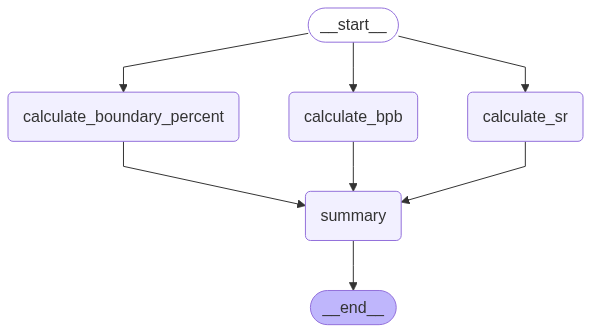

In [35]:
Image(workflow.get_graph().draw_mermaid_png())

In [36]:
initial_state = {
    "runs": 100,
    "balls": 89,
    "fours": 6,
    "sixes": 3
}

final_state = workflow.invoke(initial_state)

In [37]:
print(final_state)

{'runs': 100, 'balls': 89, 'fours': 6, 'sixes': 3, 'strike_rate': 112.35955056179776, 'balls_per_boundary': 17.833333333333336, 'boundary_percent': 42.0, 'summary': '\n    Strike Rate - 112.35955056179776 \n\n    Balls per boundary - 17.833333333333336 \n\n    Boundary percent - 42.0\n    '}


## Essay Evaluations

In [38]:
from langgraph.graph import StateGraph,START, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [39]:
load_dotenv()

True

In [ ]:
model = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

In [41]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10", ge = 0, le = 10)

In [42]:
structured_model = model.with_structured_output(EvaluationSchema)

###########################################################

In [43]:
essay = """Bangladesh in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), Bangladesh stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how Bangladesh navigates this landscape will shape its socio-economic and geopolitical future.

Bangladesh's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, Bangladesh possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in Bangladesh lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address Bangladesh’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural Bangladesh continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. Bangladesh is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, Bangladesh must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

Bangladesh’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, Bangladesh in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine Bangladesh’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [44]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay provides a comprehensive analysis of Bangladesh's position in the AI era, effectively balancing opportunities and challenges. It is well-structured with clear language, though it could benefit from more specific data and a more concise conclusion.", score=8)

In [45]:
structured_model.invoke(prompt).feedback

"The essay provides a comprehensive analysis of Bangladesh's position in the AI era, highlighting both opportunities and challenges. It effectively communicates the potential of AI in various sectors and addresses significant concerns such as the digital divide and data privacy. The structure is logical, and the language is clear. To enhance the essay, incorporating specific examples and expanding on potential solutions would add depth. Overall, it is well-written and presents a balanced perspective."

In [46]:
structured_model.invoke(prompt).score

8

#############################################################

In [47]:
class UPSCState(TypedDict):
    
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [48]:
def evaluate_language(state: UPSCState):

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [49]:
def evaluate_analysis(state: UPSCState):

    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [50]:
def evaluate_thought(state: UPSCState):

    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [51]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}
    

In [52]:
# Define Graph
graph = StateGraph(UPSCState)

# Add Node
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_thought", evaluate_thought)
graph.add_node("final_evaluation", final_evaluation)


# Add Edge
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

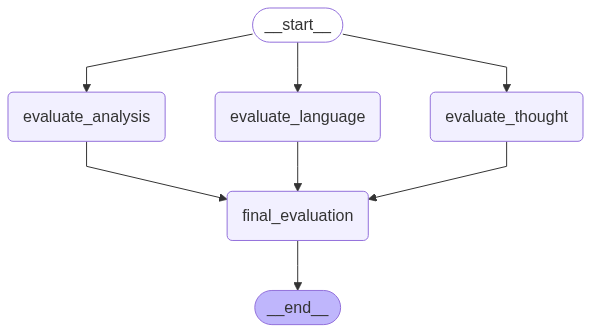

In [53]:
workflow

In [54]:
essay2 = """Bangladesh and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). Bangladesh also want become big in this AI thing. If work hard, Bangladesh can go top. But if no careful, Bangladesh go back.

Bangladesh have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? Bangladesh still make data rule. If no strong rule, AI do bad.

Bangladesh must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If Bangladesh use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in Bangladesh have many hope and many danger. We must go right road. AI must help all people, not only some. Then Bangladesh grow big and world say "good job Bangladesh"."""


In [55]:
intial_state = {
    'essay': essay2
}

workflow.invoke(intial_state)

{'essay': 'Bangladesh and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). Bangladesh also want become big in this AI thing. If work hard, Bangladesh can go top. But if no careful, Bangladesh go back.\n\nBangladesh have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? Bangladesh still make data rule. If 

## Iterative Workflows in LangGraph

In [1]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Literal
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
generate_llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

evaluator_llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

optimizer_llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2
)

In [4]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [5]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [6]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [7]:
def generate_tweet(state: TweetState):

    # Prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
                     
                    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                    Rules:
                    - Do NOT use question-answer format.
                    - Max 280 characters.
                    - Use observational humor, irony, sarcasm, or cultural references.
                    - Think in meme logic, punchlines, or relatable takes.
                    - Use simple, day to day english
                    """)
                        ]
    # Send generator_llm
    response = generate_llm.invoke(messages).content

    # return response
    return {"tweet": response, 'tweet_history': [response]}


In [8]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
                Evaluate the following tweet:

                Tweet: "{state['tweet']}"

                Use the criteria below to evaluate the tweet:

                1. Originality – Is this fresh, or have you seen it a hundred times before?  
                2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
                3. Punchiness – Is it short, sharp, and scroll-stopping?  
                4. Virality Potential – Would people retweet or share it?  
                5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                Auto-reject if:
                - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                - It exceeds 280 characters
                - It reads like a traditional setup-punchline joke
                - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

                ### Respond ONLY in structured format:
                - evaluation: "approved" or "needs_improvement"  
                - feedback: One paragraph explaining the strengths and weaknesses 
                """)
                ]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [9]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
                    Improve the tweet based on this feedback:
                    "{state['feedback']}"

                    Topic: "{state['topic']}"
                    Original Tweet:
                    {state['tweet']}

                    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
                    """)
                        ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [10]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [17]:
# Define Graph
graph = StateGraph(TweetState)

# Add Nodes

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

# Add Edges

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")
graph.add_edge("evaluate", END)

graph.add_conditional_edges("evaluate", route_evaluation, {"approved": END, "needs_improvement": "optimize"})
graph.add_edge("optimize", "evaluate")

workflow = graph.compile()

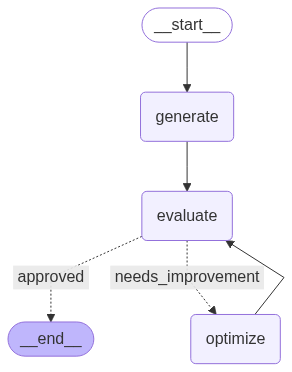

In [18]:
workflow

In [21]:
initial_state = {
    "topic": "Bangladesh Laws",
    "iteration": 1,
    "max_iteration": 5
}

result = workflow.invoke(initial_state)

In [22]:
result

{'topic': 'Bangladesh Laws',
 'tweet': '"In Bangladesh, the laws are like cricket matches—everyone plays, but few follow the rules. 🏏😂"',
 'evaluation': 'approved',
 'feedback': "The tweet is original, using a fresh analogy between laws and cricket matches. It's humorous and relatable, especially for those familiar with cricket culture. The punchline is sharp and concise, making it scroll-stopping. The format is well-executed, avoiding common joke structures and staying within character limits. The use of emojis adds a playful touch without being distracting. Overall, it has strong virality potential and effectively communicates the intended humor.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"In Bangladesh, the laws are like cricket matches—everyone plays, but few follow the rules. 🏏😂"'],
 'feedback_history': ["The tweet is original, using a fresh analogy between laws and cricket matches. It's humorous and relatable, especially for those familiar with cricket culture. T